In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Troque pelo nome do seu arquivo CSV
df = pd.read_csv('../data/DENGBR25.csv')

# Verifique se carregou
print(df.head())

C:\Users\Bruna\AppData\Local\Temp\ipykernel_576\2447789563.py:2: DtypeWarning: Columns (22,44,45,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/DENGBR25.csv')


   TP_NOT ID_AGRAVO  DT_NOTIFIC  SEM_NOT  NU_ANO  SG_UF_NOT  ID_MUNICIP  \
0       2       A90  2025-01-06   202502    2025         12      120020   
1       2       A90  2025-01-13   202503    2025         12      120020   
2       2       A90  2025-02-19   202508    2025         12      120020   
3       2       A90  2025-03-17   202512    2025         12      120020   
4       2       A90  2025-04-06   202515    2025         12      120020   

   ID_REGIONA  ID_UNIDADE  DT_SIN_PRI  ...  EVIDENCIA  PLAQ_MENOR  CON_FHD  \
0      1941.0   2000202.0  2025-01-01  ...        NaN         NaN      NaN   
1      1941.0   2002914.0  2025-01-11  ...        NaN         NaN      NaN   
2      1941.0   2000202.0  2025-02-14  ...        NaN         NaN      NaN   
3      1941.0   5336171.0  2025-03-16  ...        NaN         NaN      NaN   
4      1941.0   5336171.0  2025-03-25  ...        NaN         NaN      NaN   

  COMPLICA  TP_SISTEMA  NDUPLIC_N   DT_DIGITA  CS_FLXRET  FLXRECEBI  MIGRADO_W  

In [ ]:
df.describe()

,TP_NOT,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,SEM_PRI,ANO_NASC,NU_IDADE_N,...,PLASMATICO,EVIDENCIA,PLAQ_MENOR,CON_FHD,COMPLICA,TP_SISTEMA,NDUPLIC_N,CS_FLXRET,FLXRECEBI,MIGRADO_W
count,1605624.0,1.605624e+06,1.605624e+06,1.605624e+06,1.605624e+06,1.557265e+06,1.605464e+06,1.605624e+06,1.601051e+06,1.605624e+06,...,0.0,0.0,0.0,0.0,0.0,1587307.0,4339.0,1.605624e+06,1.0,0.0
mean,2.0,2.025155e+05,2.024999e+03,3.607638e+01,3.632703e+05,1.458755e+03,4.088451e+06,2.025149e+05,1.988136e+03,4.025077e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,3.034652e-01,2.0,NaN
std,0.0,9.558214e+00,3.678015e-02,7.121180e+00,7.084692e+04,3.807356e+02,2.612719e+06,9.487917e+00,2.007280e+01,1.308771e+02,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4.597545e-01,NaN,NaN
min,2.0,2.025010e+05,2.024000e+03,1.100000e+01,1.100010e+05,1.331000e+03,1.700000e+01,2.025010e+05,1.900000e+03,6.000000e+00,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.000000e+00,2.0,NaN
25%,2.0,2.025090e+05,2.025000e+03,3.500000e+01,3.504000e+05,1.342000e+03,2.087219e+06,2.025080e+05,1.974000e+03,4.020000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.000000e+00,2.0,NaN
50%,2.0,2.025140e+05,2.025000e+03,3.500000e+01,3.534400e+05,1.354000e+03,2.746298e+06,2.025130e+05,1.990000e+03,4.035000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.000000e+00,2.0,NaN
75%,2.0,2.025190e+05,2.025000e+03,3.500000e+01,3.555400e+05,1.465000e+03,6.595421e+06,2.025190e+05,2.004000e+03,4.050000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.000000e+00,2.0,NaN
max,2.0,2.025470e+05,2.025000e+03,5.300000e+01,5.300100e+05,6.256000e+03,9.999949e+06,2.025470e+05,2.981000e+03,4.407000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.000000e+00,2.0,NaN


In [5]:
#Drop das colunas 100% NaN
cols_100_nan = [
    "DOENCA_TRA","MANI_HEMOR","EPISTAXE","GENGIVO","METRO","PETEQUIAS",
    "HEMATURA","SANGRAM","LACO_N","PLASMATICO","EVIDENCIA","PLAQ_MENOR",
    "CON_FHD","COMPLICA","MIGRADO_W"
]
df = df.drop(columns=cols_100_nan, errors="ignore")

df.describe()

,TP_NOT,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,SEM_PRI,ANO_NASC,NU_IDADE_N,...,GRAV_METRO,GRAV_SANG,GRAV_AST,GRAV_MIOC,GRAV_CONSC,GRAV_ORGAO,TP_SISTEMA,NDUPLIC_N,CS_FLXRET,FLXRECEBI
count,1605624.0,1.605624e+06,1.605624e+06,1.605624e+06,1.605624e+06,1.557265e+06,1.605464e+06,1.605624e+06,1.601051e+06,1.605624e+06,...,2989.000000,2986.000000,2983.000000,2985.000000,2990.000000,2984.000000,1587307.0,4339.0,1.605624e+06,1.0
mean,2.0,2.025155e+05,2.024999e+03,3.607638e+01,3.632703e+05,1.458755e+03,4.088451e+06,2.025149e+05,1.988136e+03,4.025077e+03,...,1.939779,1.972539,1.939323,1.979899,1.698328,1.848525,2.0,1.0,3.034652e-01,2.0
std,0.0,9.558214e+00,3.678015e-02,7.121180e+00,7.084692e+04,3.807356e+02,2.612719e+06,9.487917e+00,2.007280e+01,1.308771e+02,...,0.237935,0.163451,0.238777,0.140368,0.459061,0.358571,0.0,0.0,4.597545e-01,NaN
min,2.0,2.025010e+05,2.024000e+03,1.100000e+01,1.100010e+05,1.331000e+03,1.700000e+01,2.025010e+05,1.900000e+03,6.000000e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0,1.0,0.000000e+00,2.0
25%,2.0,2.025090e+05,2.025000e+03,3.500000e+01,3.504000e+05,1.342000e+03,2.087219e+06,2.025080e+05,1.974000e+03,4.020000e+03,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.0,1.0,0.000000e+00,2.0
50%,2.0,2.025140e+05,2.025000e+03,3.500000e+01,3.534400e+05,1.354000e+03,2.746298e+06,2.025130e+05,1.990000e+03,4.035000e+03,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,1.0,0.000000e+00,2.0
75%,2.0,2.025190e+05,2.025000e+03,3.500000e+01,3.555400e+05,1.465000e+03,6.595421e+06,2.025190e+05,2.004000e+03,4.050000e+03,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,1.0,1.000000e+00,2.0
max,2.0,2.025470e+05,2.025000e+03,5.300000e+01,5.300100e+05,6.256000e+03,9.999949e+06,2.025470e+05,2.981000e+03,4.407000e+03,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,1.0,1.000000e+00,2.0


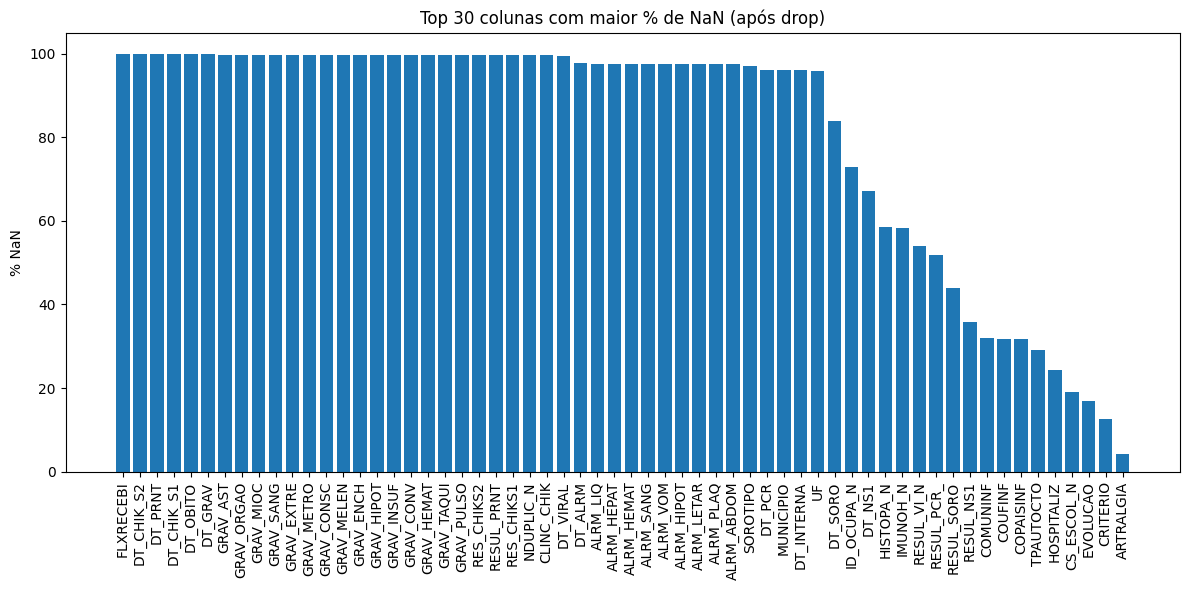

In [8]:
nan_pct = (df.isna().mean() * 100).sort_values(ascending=False)

top = nan_pct.head(60)

plt.figure(figsize=(12, 6))
plt.bar(top.index.astype(str), top.values)
plt.xticks(rotation=90)
plt.ylabel('% NaN')
plt.title('Top 30 colunas com maior % de NaN (após drop)')
plt.tight_layout()
plt.show()






